In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score
SEED = 42

In [9]:
df=pd.read_excel('sleeep_apnea_data.xlsx')
df.sample(n=6)

,Gender,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI
1559,M,0.0,16.0,29.744200,80.0,164.0,55.0,39.0,93.0,103.0,40.0,54.918033
4331,F,1.0,7.0,19.777699,50.0,159.0,53.5,28.0,62.0,93.5,34.0,3.150000
3989,M,1.0,5.0,26.953125,69.0,160.0,55.5,39.0,95.5,99.0,79.0,10.927835
3657,M,1.0,14.0,27.609452,77.0,167.0,57.0,41.0,101.0,98.5,64.0,48.108108
3093,M,0.0,0.0,22.229062,65.0,171.0,55.5,35.0,85.0,98.0,56.0,0.147783
5227,F,0.0,10.0,24.608226,55.0,149.5,53.0,33.0,84.0,84.5,75.0,32.050000


In [10]:
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  5245
Columns  :  12

Features : 
 ['Gender', 'BQ', 'ESS', 'BMI', 'Weight', 'Height', 'Head', 'Neck', 'Waist', 'Buttock', 'Age', 'AHI']

Missing values :   5

Unique values :  
 Gender        2
BQ            4
ESS          31
BMI        2092
Weight      441
Height      120
Head        127
Neck        169
Waist       262
Buttock     212
Age          63
AHI        4387
dtype: int64


In [11]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gender   5245 non-null   object 
 1   BQ       5243 non-null   float64
 2   ESS      5244 non-null   float64
 3   BMI      5245 non-null   float64
 4   Weight   5245 non-null   float64
 5   Height   5245 non-null   float64
 6   Head     5245 non-null   float64
 7   Neck     5245 non-null   float64
 8   Waist    5245 non-null   float64
 9   Buttock  5243 non-null   float64
 10  Age      5245 non-null   float64
 11  AHI      5245 non-null   float64
dtypes: float64(11), object(1)
memory usage: 491.8+ KB


Gender     0
BQ         2
ESS        1
BMI        0
Weight     0
Height     0
Head       0
Neck       0
Waist      0
Buttock    2
Age        0
AHI        0
dtype: int64

In [12]:
df.describe()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI
count,5243.000000,5244.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5245.000000,5243.000000,5245.000000,5245.000000
mean,0.231928,10.177918,26.617869,75.519104,168.049094,56.433451,37.703125,91.213613,100.877284,45.363699,31.590983
std,0.442405,20.189258,5.366641,17.472181,8.148584,2.286539,4.197489,13.826014,9.732286,13.105781,28.138630
min,0.000000,0.000000,14.765497,37.000000,140.000000,36.500000,26.000000,56.000000,70.000000,20.000000,0.000000
25%,0.000000,6.000000,23.120624,64.000000,163.000000,55.000000,35.000000,83.000000,95.000000,35.000000,6.341463
50%,0.000000,10.000000,25.795918,74.000000,169.000000,56.500000,37.500000,90.000000,99.500000,45.000000,23.890000
75%,0.000000,14.000000,29.017447,85.000000,174.000000,58.000000,40.000000,98.500000,105.000000,55.000000,52.720000
max,9.000000,999.000000,60.232426,178.000000,198.000000,69.500000,60.000000,182.000000,179.000000,80.000000,143.922830


In [13]:
dummies = pd.get_dummies(df.Gender)
dummies.head()

,F,M
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [14]:
merged = pd.concat([df,dummies],axis='columns')
merged.head()

,Gender,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,F,M
0,M,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,0,1
1,M,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,0,1
2,M,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,0,1
3,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1
4,M,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,0,1


In [15]:
df = merged.drop(['Gender'], axis='columns')
df


,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,F,M
0,0.0,14.0,29.065927,88.0,174.0,57.500000,39.0,95.5,106.5,20.0,2.903226,0,1
1,0.0,8.0,26.989619,78.0,170.0,57.000000,36.5,90.0,100.0,20.0,1.022727,0,1
2,0.0,16.0,23.939481,75.0,177.0,59.000000,39.0,88.0,104.0,20.0,0.518359,0,1
3,0.0,15.0,22.129740,67.0,174.0,57.000000,35.0,74.0,94.0,20.0,0.559006,0,1
4,0.0,15.0,22.129740,67.0,174.0,57.000000,35.0,74.0,94.0,20.0,0.559006,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5240,1.0,6.0,24.005487,63.0,162.0,57.000000,33.0,99.0,101.5,77.0,35.960000,1,0
5241,0.0,13.0,29.964328,63.0,145.0,53.000000,35.8,102.0,112.0,77.0,31.640000,1,0
5242,0.0,13.0,29.964328,63.0,145.0,53.000000,35.8,102.0,112.0,77.0,31.640000,1,0
5243,0.0,0.0,24.654832,60.0,156.0,54.500000,35.0,83.5,99.0,79.0,35.110000,1,0


In [16]:
df = df.drop(['F'], axis='columns')
df.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,M
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,1
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,1
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,1
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1


In [17]:
def fun(num): 
  
    if num>=30: 
        return 3
    elif num in range (15,30):
        return 2
    elif num in range (5,15):
        return 1
    else:
        return 0
    

In [18]:
df['status']=df.AHI.apply(fun)
status=["Normal","Mild","Moderate","Severe"]

In [19]:
df.head(10)

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,AHI,M,status
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,2.903226,1,0
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1.022727,1,0
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,0.518359,1,0
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1,0
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,0.559006,1,0
5,0.0,5.0,20.761246,60.0,170.0,56.0,35.0,68.0,90.0,20.0,0.693642,1,0
6,0.0,12.0,22.656114,68.2,173.5,57.0,34.5,76.5,97.0,20.0,1.730769,1,0
7,0.0,0.0,33.910035,98.0,170.0,57.0,39.0,108.0,123.0,20.0,73.861386,1,3
8,0.0,9.0,24.489796,75.0,175.0,58.0,37.0,91.0,100.0,21.0,6.646707,1,0
9,0.0,12.0,25.524316,72.9,169.0,56.5,38.5,88.0,97.5,21.0,2.763158,1,0


In [20]:
df = df.drop(['AHI'], axis='columns')
df.head(10)

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,1,0
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1,0
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,1,0
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0
5,0.0,5.0,20.761246,60.0,170.0,56.0,35.0,68.0,90.0,20.0,1,0
6,0.0,12.0,22.656114,68.2,173.5,57.0,34.5,76.5,97.0,20.0,1,0
7,0.0,0.0,33.910035,98.0,170.0,57.0,39.0,108.0,123.0,20.0,1,3
8,0.0,9.0,24.489796,75.0,175.0,58.0,37.0,91.0,100.0,21.0,1,0
9,0.0,12.0,25.524316,72.9,169.0,56.5,38.5,88.0,97.5,21.0,1,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5245 entries, 0 to 5244
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BQ       5243 non-null   float64
 1   ESS      5244 non-null   float64
 2   BMI      5245 non-null   float64
 3   Weight   5245 non-null   float64
 4   Height   5245 non-null   float64
 5   Head     5245 non-null   float64
 6   Neck     5245 non-null   float64
 7   Waist    5245 non-null   float64
 8   Buttock  5243 non-null   float64
 9   Age      5245 non-null   float64
 10  M        5245 non-null   uint8  
 11  status   5245 non-null   int64  
dtypes: float64(10), int64(1), uint8(1)
memory usage: 456.0 KB


In [22]:
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : \n', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  5245
Columns  :  12

Features : 
 ['BQ', 'ESS', 'BMI', 'Weight', 'Height', 'Head', 'Neck', 'Waist', 'Buttock', 'Age', 'M', 'status']

Missing values :   5

Unique values :  
 BQ            4
ESS          31
BMI        2092
Weight      441
Height      120
Head        127
Neck        169
Waist       262
Buttock     212
Age          63
M             2
status        4
dtype: int64


In [23]:
df = df.dropna()
df.shape

(5241, 12)

In [24]:
print ('\nMissing values :  ', df.isnull().sum().values.sum())


Missing values :   0


0    2903
3    2308
1      17
2      13
Name: status, dtype: int64


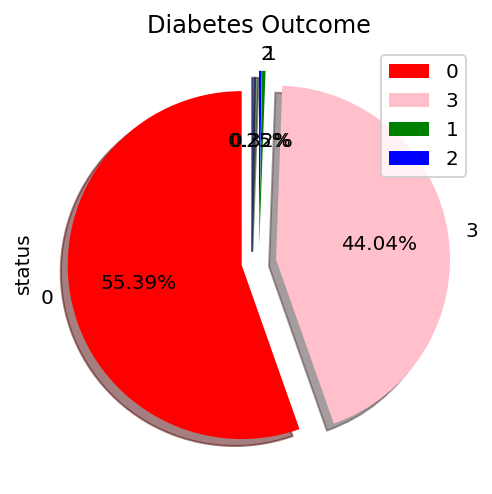

In [25]:
print(df.status.value_counts())
color=['r',"pink","green","blue"]
df['status'].value_counts().plot.pie(colors=color,startangle=90, shadow=True,explode=(0.1, 0.1, 0.1, 0.1), autopct='%1.2f%%').set_title('Diabetes Outcome')
plt.legend()
plt.show()

In [26]:
import seaborn as sns

In [27]:
df['Age'].isnull().sum()

0

<AxesSubplot:xlabel='BQ', ylabel='Density'>

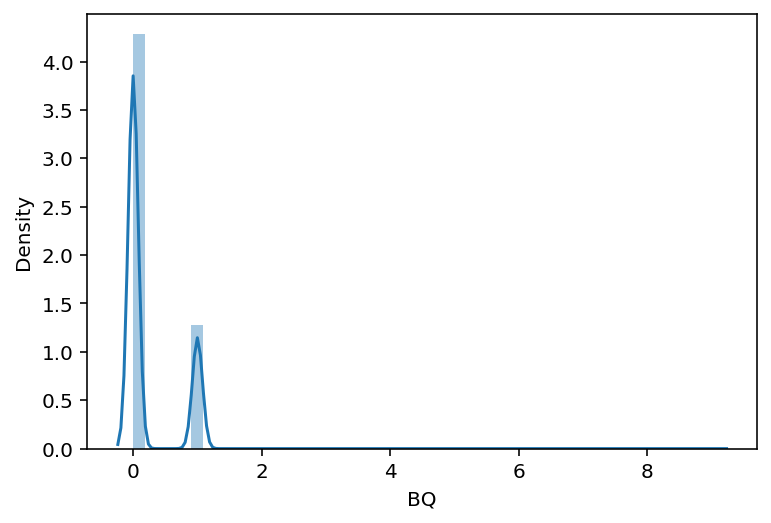

In [28]:
sns.distplot(df['BQ'])

Text(0, 0.5, 'No of persons')

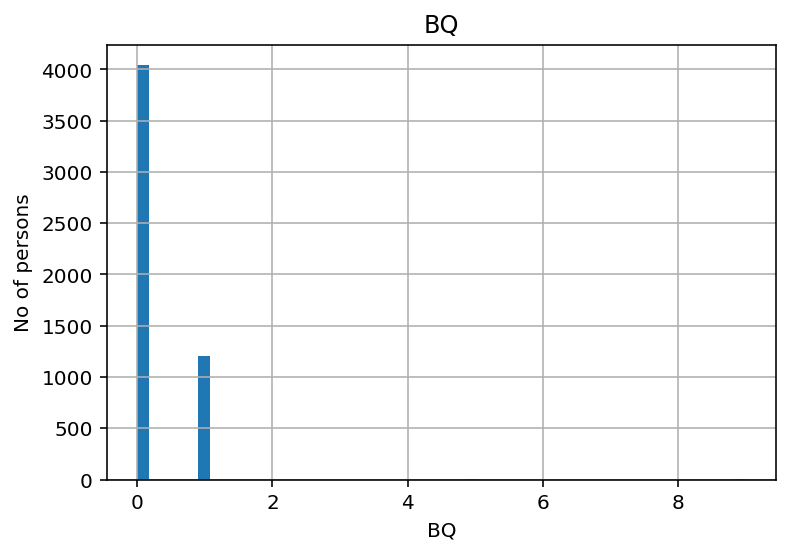

In [29]:
figure=df.BQ.hist(bins=50)
figure.set_title('BQ')
figure.set_xlabel('BQ')
figure.set_ylabel('No of persons')

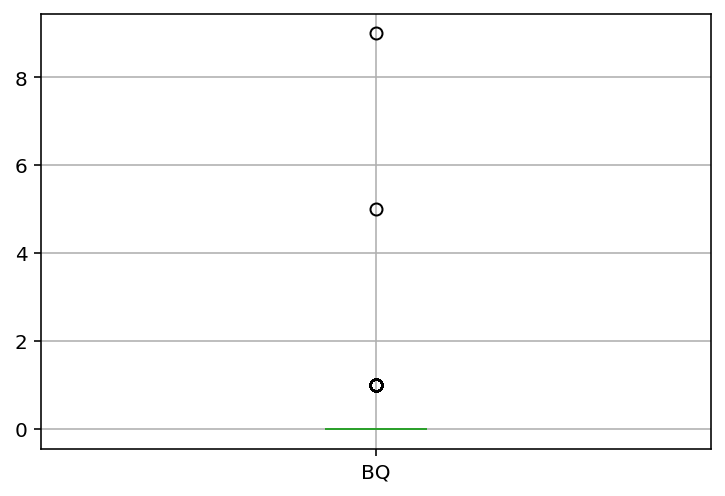

In [30]:
figure=df.boxplot(column="BQ")

In [31]:
uppper_boundary=df['BQ'].mean() + 3* df['BQ'].std()
lower_boundary=df['BQ'].mean() - 3* df['BQ'].std()
print(lower_boundary), print(uppper_boundary),print(df['BQ'].mean())
print(df.shape)

-1.0952254151899443
1.5588773900039112
0.2318259874069834
(5241, 12)


In [32]:
df[(df.BQ<lower_boundary)|(df.BQ>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
2545,9.0,0.0,24.622961,72.0,171.0,57.5,35.0,84.5,94.0,50.0,1,0
4626,5.0,2.0,17.146776,45.0,162.0,51.5,28.0,69.5,87.5,46.0,0,0


In [33]:
df_no_outlier = df[(df.BQ>lower_boundary)&(df.BQ<uppper_boundary)]
df_no_outlier.shape

(5239, 12)

<AxesSubplot:xlabel='ESS', ylabel='Density'>

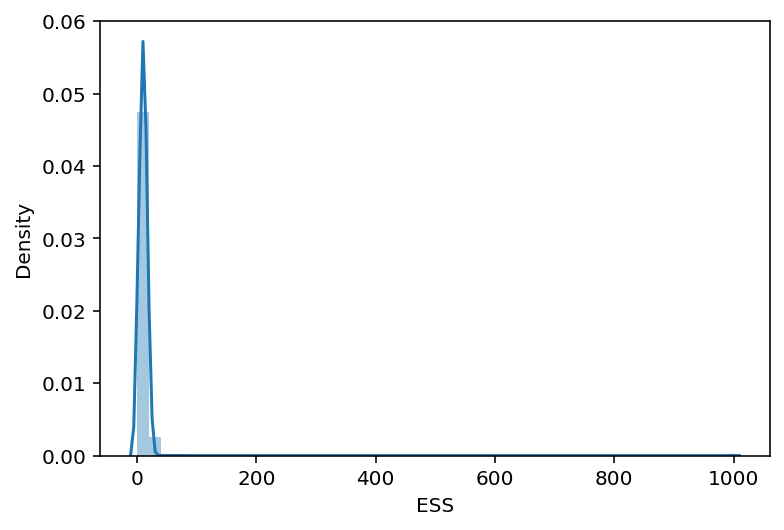

In [34]:
sns.distplot(df_no_outlier['ESS'])

Text(0, 0.5, 'No of persons')

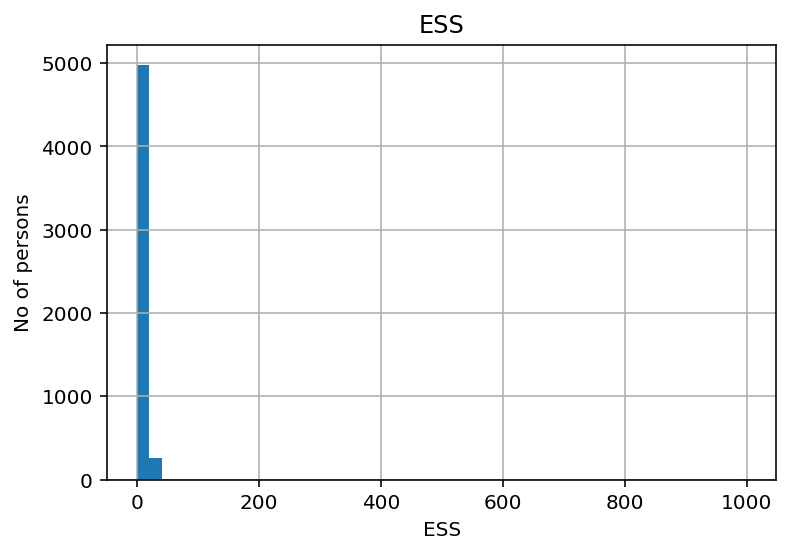

In [35]:
figure=df_no_outlier.ESS.hist(bins=50)
figure.set_title('ESS')
figure.set_xlabel('ESS')
figure.set_ylabel('No of persons')

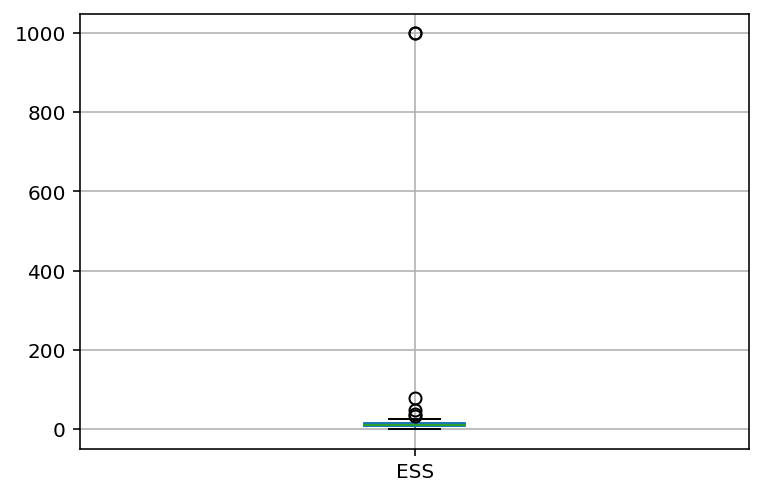

In [36]:
figure=df_no_outlier.boxplot(column="ESS")

### Interquantile range

In [37]:
Q1 = df_no_outlier.ESS.quantile(0.05)
Q3 = df_no_outlier.ESS.quantile(0.95)
Q1, Q3

(0.0, 20.0)

In [38]:
IQR = Q3 - Q1
IQR

20.0

In [39]:
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR
lower_limit, upper_limit

(-30.0, 50.0)

In [40]:
df_no_outlier[(df_no_outlier.ESS<lower_limit)|(df_no_outlier.ESS>upper_limit)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
2049,1.0,999.0,20.242215,58.500000,170.0,55.5,36.5,71.0,89.0,45.0,1,0
3413,1.0,999.0,29.069767,86.000000,172.0,56.5,42.0,104.0,108.0,60.0,1,0
3649,1.0,79.0,24.807473,78.599998,178.0,63.0,42.0,94.0,98.5,64.0,1,0


In [41]:
df_no_outlier = df_no_outlier[(df_no_outlier.ESS>lower_limit) &(df_no_outlier.ESS<upper_limit)]
df_no_outlier.shape

(5236, 12)

<AxesSubplot:xlabel='BMI', ylabel='Density'>

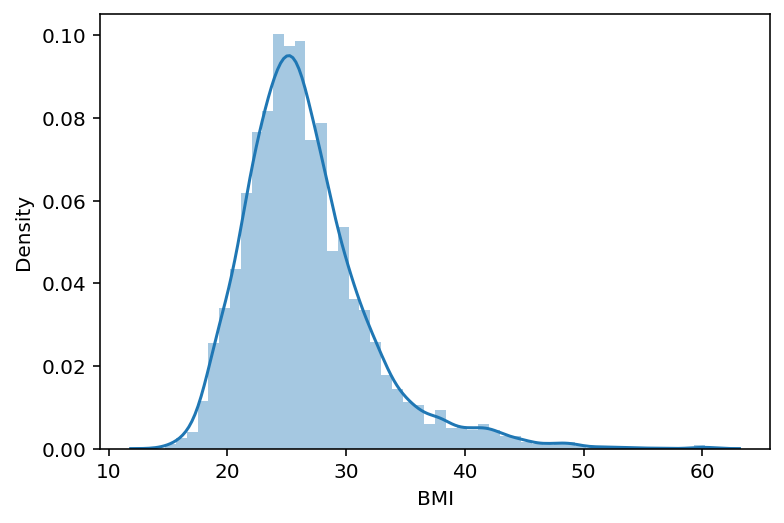

In [42]:
sns.distplot(df_no_outlier['BMI'])

(0.0, 100.0)

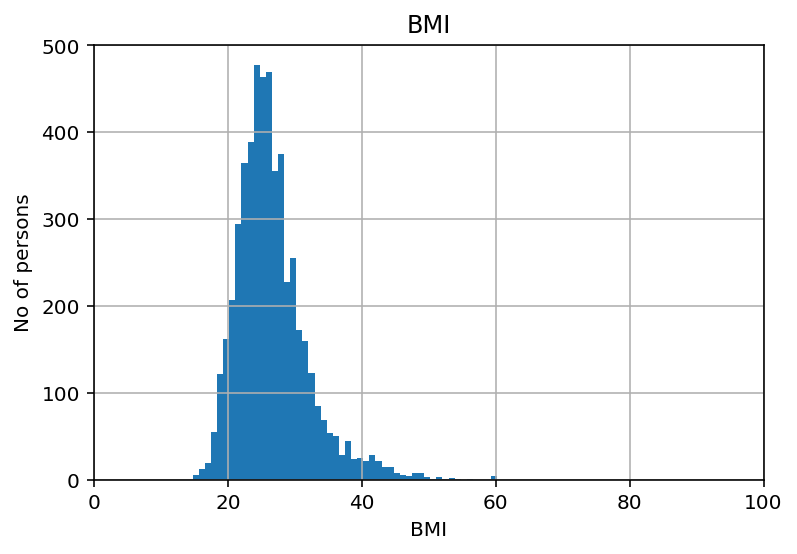

In [43]:
figure=df_no_outlier.BMI.hist(bins=50)
figure.set_title('BMI')
figure.set_xlabel('BMI')
figure.set_ylabel('No of persons')
figure.set_xlim([0, 100])



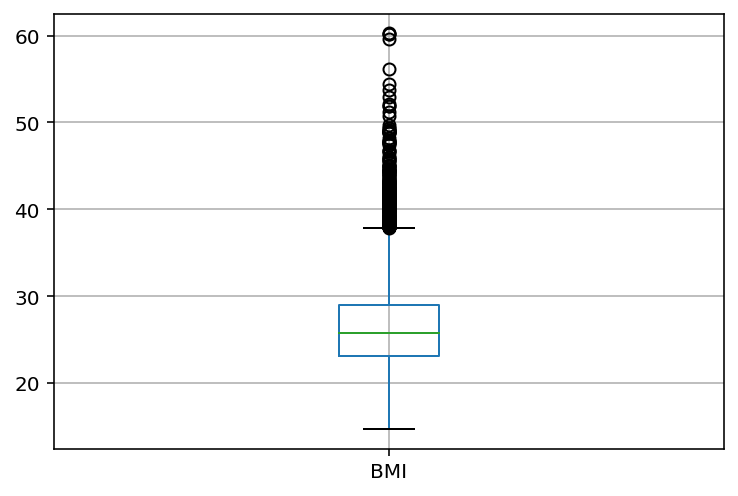

In [44]:
figure=df_no_outlier.boxplot(column="BMI")

In [45]:
uppper_boundary=df_no_outlier['BMI'].mean() + 3* df_no_outlier['BMI'].std()
lower_boundary=df_no_outlier['BMI'].mean() - 3* df_no_outlier['BMI'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['BMI'].mean())
print(df_no_outlier.shape)

10.556856975855116
42.6790907472389
26.61797386154701
(5236, 12)


In [46]:
df_no_outlier[(df_no_outlier.BMI<lower_boundary)|(df_no_outlier.BMI>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
57,0.0,4.0,43.303176,161.3,193.0,58.0,42.0,137.0,137.0,23.0,1,0
76,0.0,8.0,43.027717,120.0,167.0,61.0,46.5,118.8,126.5,23.0,1,3
144,0.0,3.0,47.839506,155.0,180.0,61.0,45.8,132.5,144.0,25.0,1,3
152,0.0,7.0,60.232426,170.0,168.0,62.0,49.0,159.0,179.0,25.0,1,3
260,0.0,15.0,44.982699,130.0,170.0,59.0,50.5,137.0,131.0,27.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4442,0.0,11.0,43.516184,113.5,161.5,57.5,41.0,134.0,129.0,38.0,0,3
4501,0.0,6.0,43.282548,100.0,152.0,54.0,38.0,108.0,127.0,40.0,0,3
4625,0.0,0.0,48.850916,123.5,159.0,56.5,45.5,127.0,137.5,45.0,0,3
4827,0.0,14.0,46.077003,110.7,155.0,57.0,37.0,147.0,147.0,52.0,0,0


In [47]:
df_no_outlier = df_no_outlier[(df_no_outlier.BMI>lower_boundary)&(df_no_outlier.BMI<uppper_boundary)]
df_no_outlier.shape

(5153, 12)

<AxesSubplot:xlabel='Weight', ylabel='Density'>

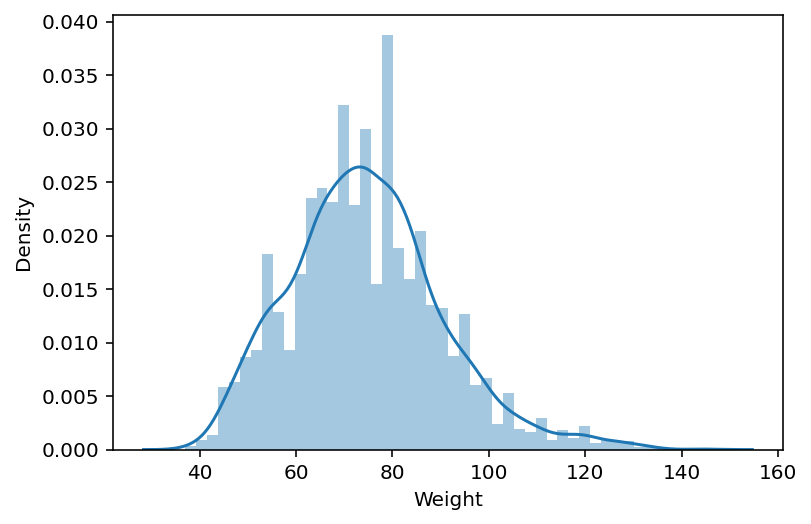

In [48]:
sns.distplot(df_no_outlier['Weight'])

Text(0, 0.5, 'No of persons')

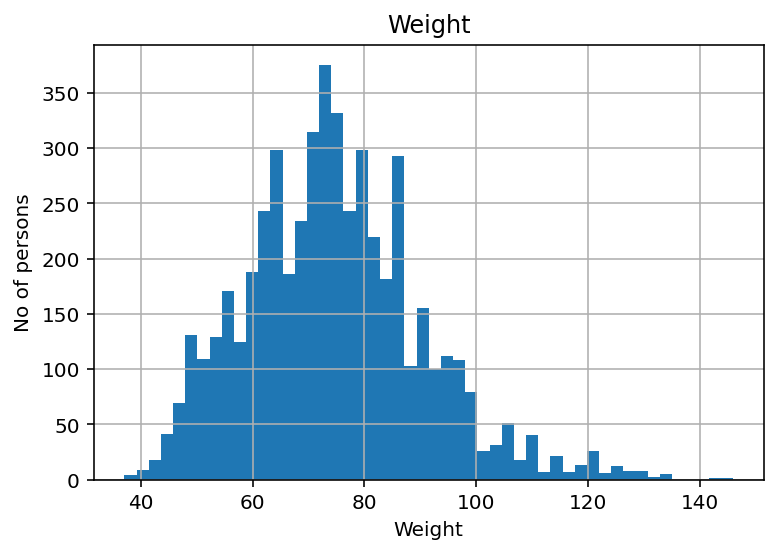

In [49]:
figure=df_no_outlier.Weight.hist(bins=50)
figure.set_title('Weight')
figure.set_xlabel('Weight')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



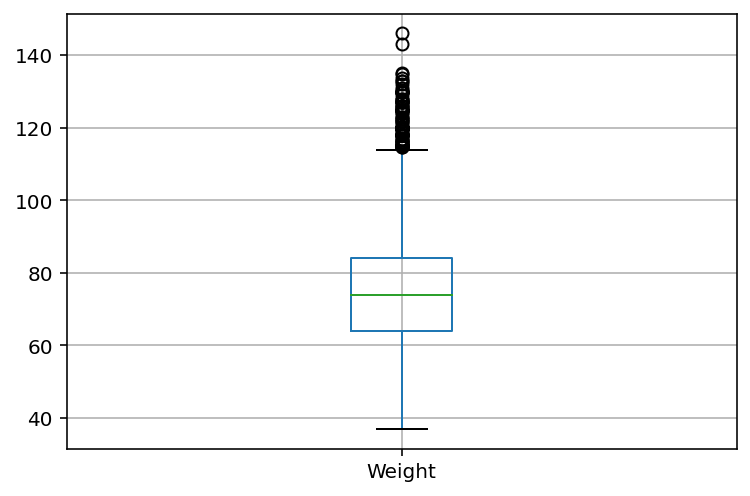

In [50]:
figure=df_no_outlier.boxplot(column="Weight")

In [51]:
uppper_boundary=df_no_outlier['Weight'].mean() + 3* df_no_outlier['Weight'].std()
lower_boundary=df_no_outlier['Weight'].mean() - 3* df_no_outlier['Weight'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Weight'].mean())
print(df_no_outlier.shape)

27.027429303512314
122.16542922431543
74.59642926391388
(5153, 12)


In [52]:
df_no_outlier[(df_no_outlier.Weight<lower_boundary)|(df_no_outlier.Weight>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
25,1.0,9.0,39.116323,129.0,181.6,60.8,45.5,116.0,136.0,21.0,1,3
41,1.0,7.0,42.369889,135.0,178.5,57.0,44.2,130.0,124.0,22.0,1,0
48,0.0,8.0,39.917606,127.9,179.0,59.0,43.0,125.0,120.0,22.0,1,3
55,0.0,12.0,40.999483,127.0,176.0,59.5,44.0,117.5,123.8,22.0,1,3
74,0.0,0.0,39.893696,133.6,183.0,60.0,44.0,123.0,126.0,23.0,1,0
145,0.0,8.0,41.751265,146.0,187.0,63.0,48.0,127.0,127.0,25.0,1,0
149,1.0,7.0,38.818717,130.0,183.0,60.0,45.0,131.0,138.0,25.0,1,3
159,1.0,12.0,42.252569,125.0,172.0,61.5,45.0,123.5,133.5,25.0,1,3
161,0.0,11.0,36.330340,123.0,184.0,61.0,43.0,123.0,123.0,25.0,1,3
299,0.0,9.0,40.822277,133.0,180.5,62.5,43.0,119.0,124.0,28.0,1,3


In [53]:
df_no_outlier = df_no_outlier[(df_no_outlier.Weight>lower_boundary)&(df_no_outlier.Weight<uppper_boundary)]
df_no_outlier.shape

(5110, 12)

<AxesSubplot:xlabel='Height', ylabel='Density'>

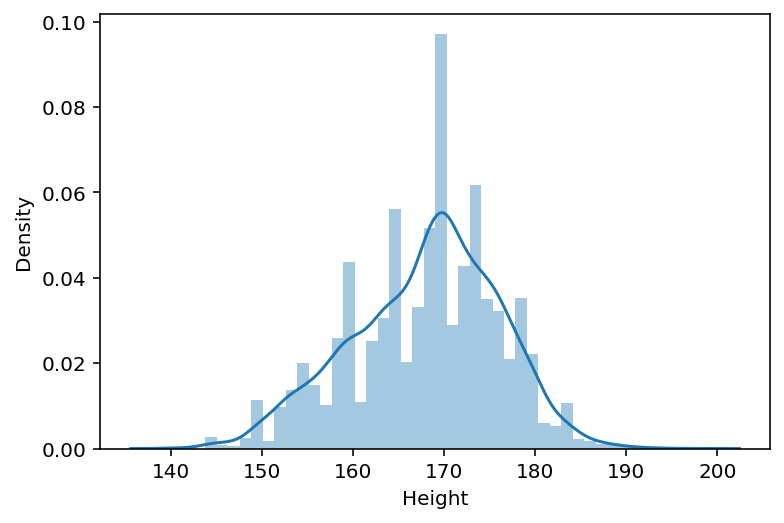

In [54]:
sns.distplot(df_no_outlier['Height'])

Text(0, 0.5, 'No of persons')

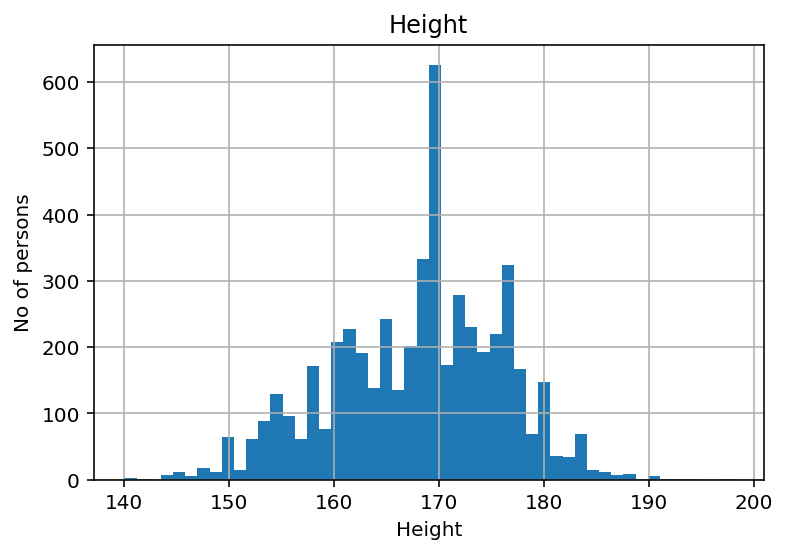

In [55]:
figure=df_no_outlier.Height.hist(bins=50)
figure.set_title('Height')
figure.set_xlabel('Height')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



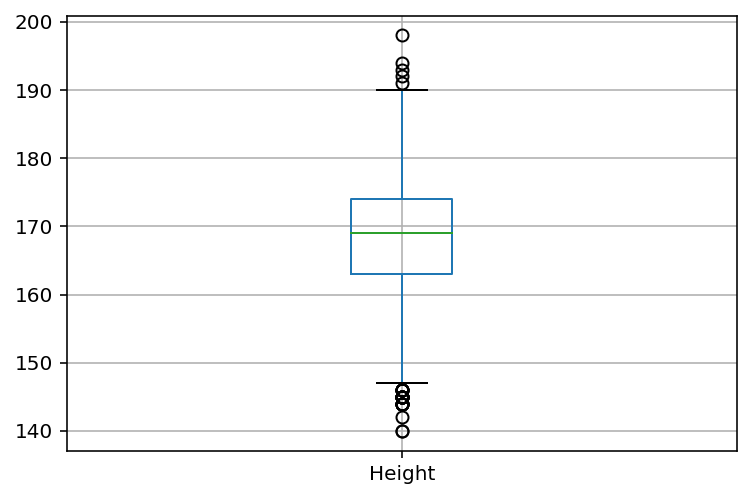

In [56]:
figure=df_no_outlier.boxplot(column="Height")

In [57]:
uppper_boundary=df_no_outlier['Height'].mean() + 3* df_no_outlier['Height'].std()
lower_boundary=df_no_outlier['Height'].mean() - 3* df_no_outlier['Height'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Height'].mean())
print(df_no_outlier.shape)

143.64168759997148
192.2813260986586
167.96150684931504
(5110, 12)


In [58]:
df_no_outlier[(df_no_outlier.Height<lower_boundary)|(df_no_outlier.Height>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
138,0.0,2.0,14.765497,55.0,193.0,56.5,34.0,67.5,87.0,25.0,1,0
1273,0.0,13.0,19.927729,75.0,194.0,57.0,37.0,90.5,102.0,37.0,1,3
1908,1.0,7.0,23.977145,94.0,198.0,58.5,39.0,101.0,105.0,43.0,1,3
4464,1.0,4.0,24.489796,48.0,140.0,56.0,36.0,96.0,94.0,39.0,0,3
4514,0.0,0.0,24.489796,48.0,140.0,55.2,30.5,95.5,95.0,41.0,0,0
5177,0.0,0.0,27.772267,56.0,142.0,54.0,36.0,94.0,98.0,68.0,0,3


In [59]:
df_no_outlier = df_no_outlier[(df_no_outlier.Height>lower_boundary)&(df_no_outlier.Height<uppper_boundary)]
df_no_outlier.shape

(5104, 12)

<AxesSubplot:xlabel='Head', ylabel='Density'>

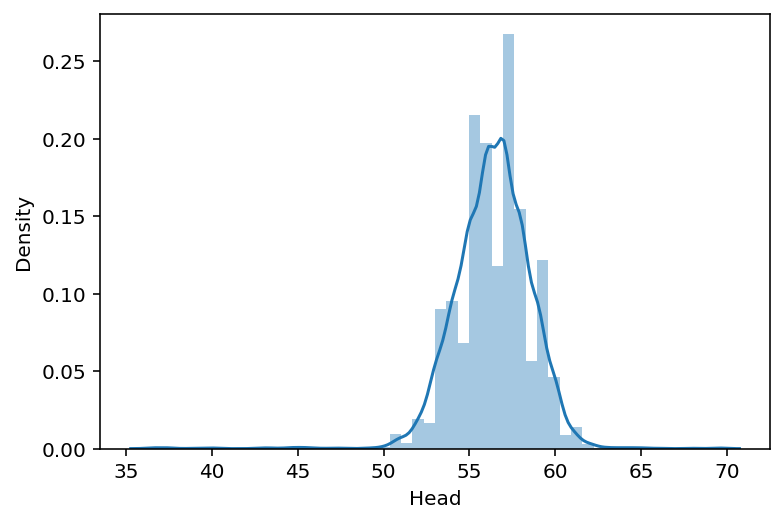

In [256]:
sns.distplot(df_no_outlier['Head'])

Text(0, 0.5, 'No of persons')

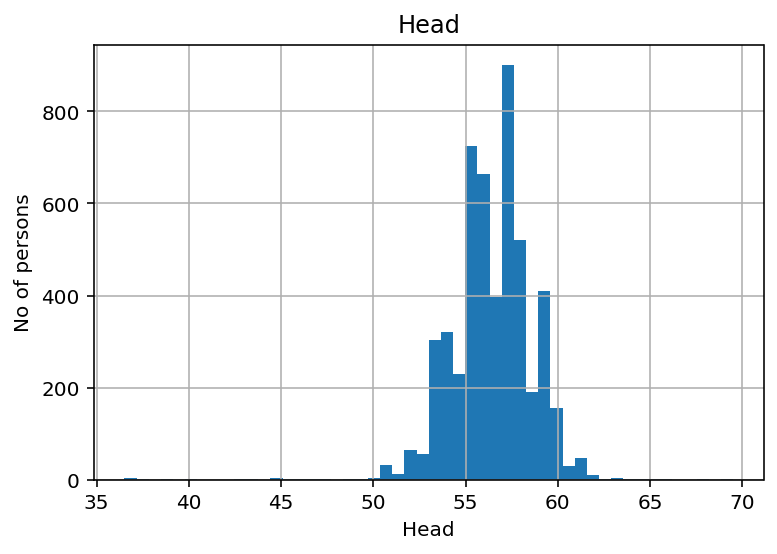

In [257]:
figure=df_no_outlier.Head.hist(bins=50)
figure.set_title('Head')
figure.set_xlabel('Head')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



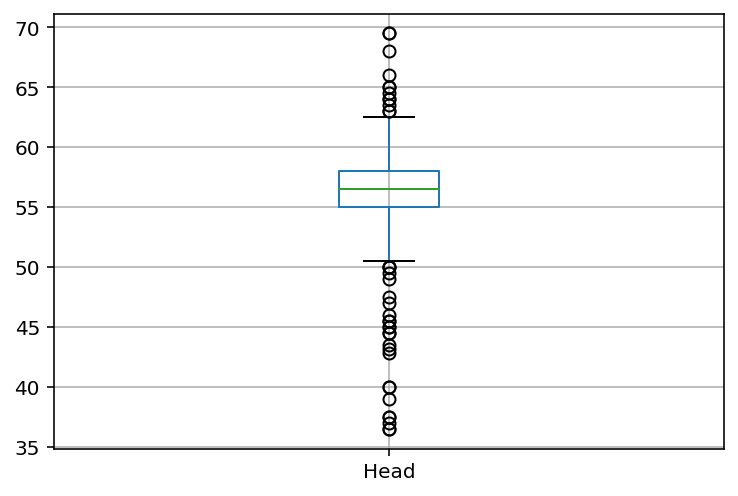

In [258]:
figure=df_no_outlier.boxplot(column="Head")

In [259]:
uppper_boundary=df_no_outlier['Head'].mean() + 3* df_no_outlier['Head'].std()
lower_boundary=df_no_outlier['Head'].mean() - 3* df_no_outlier['Head'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Head'].mean())
print(df_no_outlier.shape)

49.65471551453164
63.08119749726439
56.367956505898015
(5104, 12)


In [260]:
df_no_outlier[(df_no_outlier.Head<lower_boundary)|(df_no_outlier.Head>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
29,0.0,18.0,25.180785,78.0,176.0,36.5,37.0,88.5,102.0,22.0,1,0
201,0.0,0.0,21.967120,62.0,168.0,42.8,33.5,78.0,92.5,26.0,1,0
291,0.0,14.0,22.340297,74.0,182.0,45.0,34.2,80.5,96.5,28.0,1,0
490,0.0,14.0,25.593737,68.0,163.0,45.0,36.5,87.5,94.0,31.0,1,0
565,0.0,16.0,40.745465,115.0,168.0,68.0,52.0,124.0,126.0,31.0,1,3
656,0.0,12.0,23.054562,69.0,173.0,65.0,35.0,84.0,96.0,32.0,1,0
1425,1.0,10.0,25.142857,77.0,175.0,45.5,38.5,89.0,103.5,39.0,1,0
1446,0.0,16.0,20.478267,62.0,174.0,37.5,35.0,80.0,89.0,39.0,1,3
1499,1.0,9.0,25.648918,75.0,171.0,47.5,38.0,87.0,100.0,40.0,1,0
1883,0.0,13.0,38.016529,103.5,165.0,65.0,42.0,118.0,113.0,43.0,1,3


In [261]:
df_no_outlier = df_no_outlier[(df_no_outlier.Head>lower_boundary)&(df_no_outlier.Head<uppper_boundary)]
df_no_outlier.shape

(5072, 12)

<AxesSubplot:xlabel='Neck', ylabel='Density'>

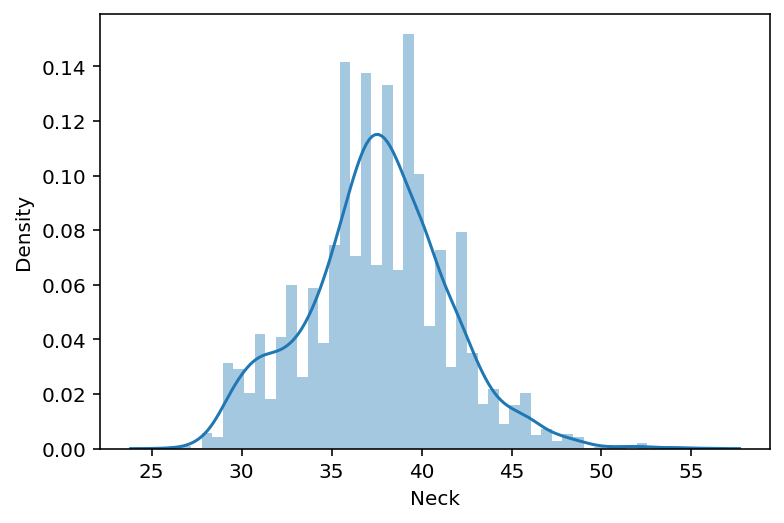

In [262]:
sns.distplot(df_no_outlier['Neck'])

Text(0, 0.5, 'No of persons')

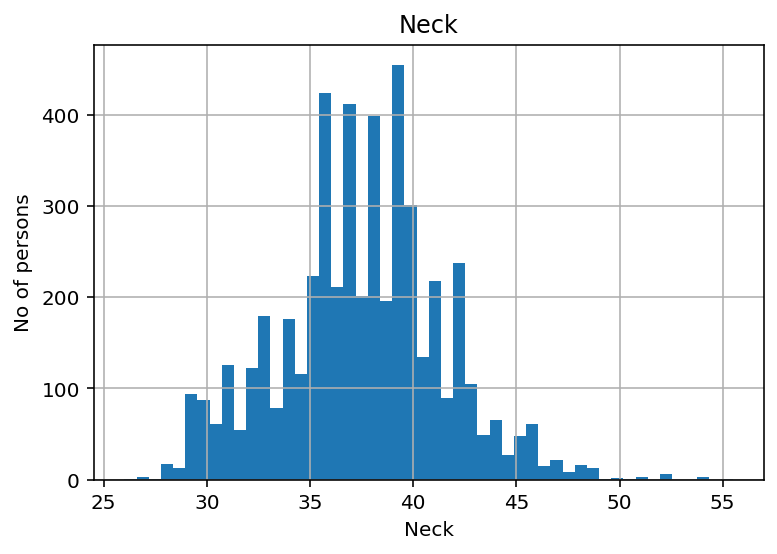

In [263]:
figure=df_no_outlier.Neck.hist(bins=50)
figure.set_title('Neck')
figure.set_xlabel('Neck')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



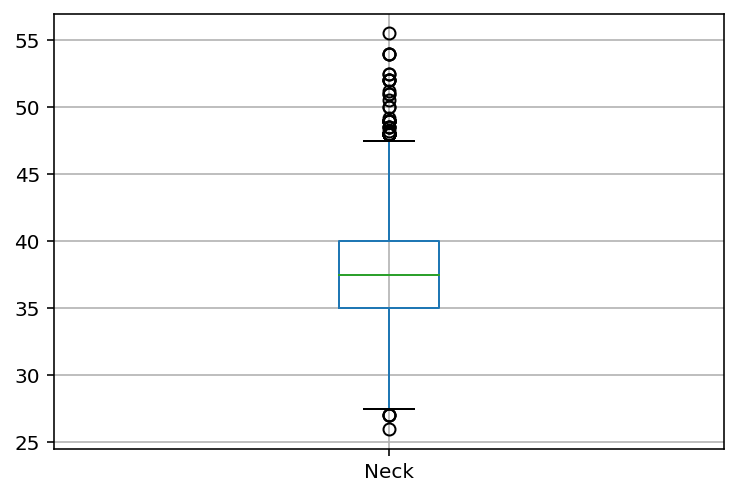

In [264]:
figure=df_no_outlier.boxplot(column="Neck")

In [265]:
uppper_boundary=df_no_outlier['Neck'].mean() + 3* df_no_outlier['Neck'].std()
lower_boundary=df_no_outlier['Neck'].mean() - 3* df_no_outlier['Neck'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Neck'].mean())
print(df_no_outlier.shape)

25.572171324562255
49.4447411369081
37.50845623073518
(5072, 12)


In [266]:
df_no_outlier[(df_no_outlier.Neck<lower_boundary)|(df_no_outlier.Neck>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
986,0.0,7.0,18.906901,54.0,169.0,55.0,54.0,71.0,86.0,35.0,1,0
987,0.0,7.0,18.906901,54.0,169.0,55.0,54.0,71.0,86.0,35.0,1,0
1653,1.0,4.0,29.860551,100.0,183.0,60.0,50.5,131.0,126.0,41.0,1,3
1853,1.0,13.0,41.176471,119.0,170.0,58.0,52.0,122.0,106.0,43.0,1,3
2127,0.0,11.0,32.716049,106.0,180.0,61.0,52.0,117.0,122.0,45.0,1,3
2191,0.0,11.0,40.094891,120.0,173.0,60.0,52.0,132.0,131.0,46.0,1,3
2420,0.0,12.0,34.184933,94.2,166.0,57.5,55.5,105.5,105.0,48.0,1,3
3059,0.0,10.0,30.116213,85.0,168.0,58.0,52.0,111.0,107.0,55.0,1,3
3118,1.0,9.0,26.609713,76.0,169.0,59.5,54.0,98.0,94.0,56.0,1,0
3165,0.0,0.0,18.778345,53.0,168.0,56.0,51.0,74.5,88.0,56.0,1,3


In [267]:
df_no_outlier = df_no_outlier[(df_no_outlier.Neck>lower_boundary)&(df_no_outlier.Neck<uppper_boundary)]
df_no_outlier.shape

(5056, 12)

<AxesSubplot:xlabel='Waist', ylabel='Density'>

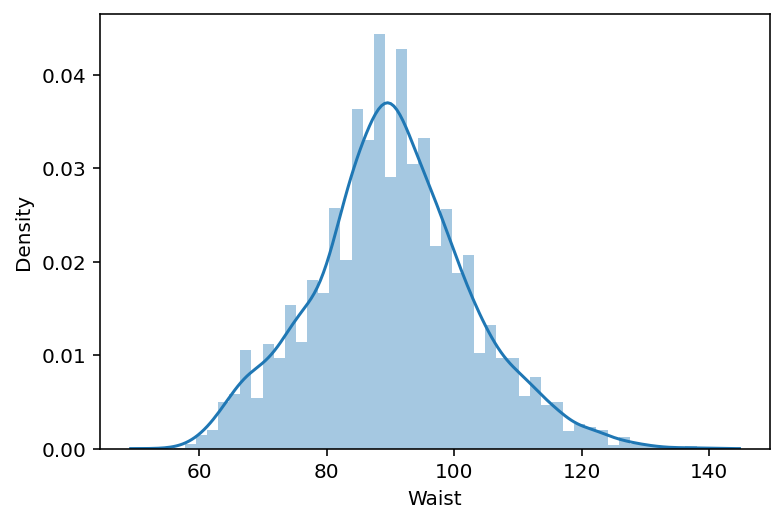

In [268]:
sns.distplot(df_no_outlier['Waist'])

Text(0, 0.5, 'No of persons')

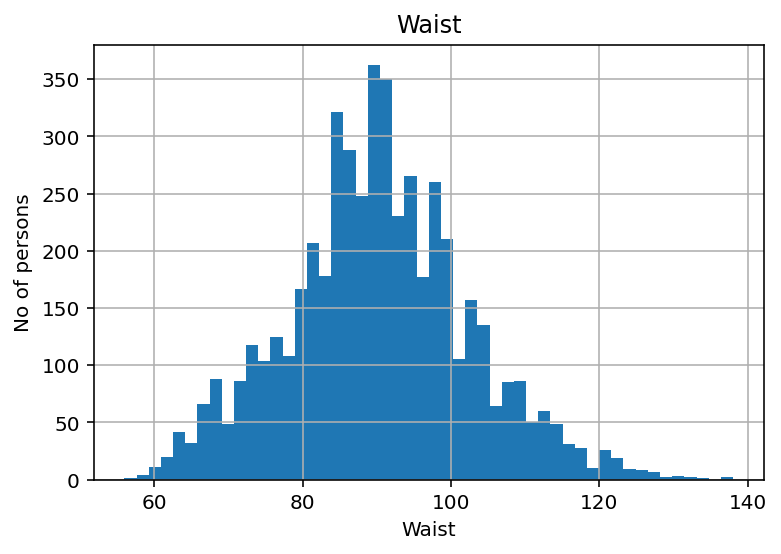

In [269]:
figure=df_no_outlier.Waist.hist(bins=50)
figure.set_title('Waist')
figure.set_xlabel('Waist')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



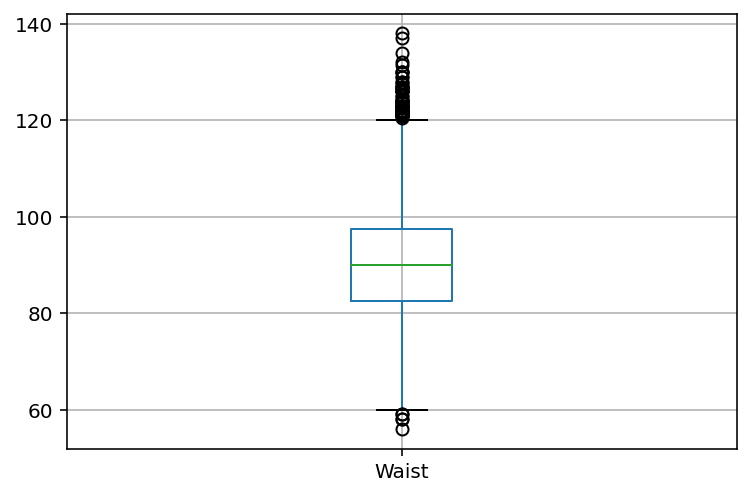

In [270]:
figure=df_no_outlier.boxplot(column="Waist")

In [271]:
uppper_boundary=df_no_outlier['Waist'].mean() + 3* df_no_outlier['Waist'].std()
lower_boundary=df_no_outlier['Waist'].mean() - 3* df_no_outlier['Waist'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Waist'].mean())
print(df_no_outlier.shape)

53.21396328173027
127.24454146510517
90.22925237341772
(5056, 12)


In [272]:
df_no_outlier[(df_no_outlier.Waist<lower_boundary)|(df_no_outlier.Waist>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
53,1.0,18.0,41.522491,120.0,170.0,61.0,47.0,131.5,126.5,22.0,1,3
400,0.0,19.0,37.551020,115.0,175.0,59.5,40.5,130.0,121.0,29.0,1,3
457,0.0,11.0,37.551020,115.0,175.0,58.0,39.5,130.0,122.0,30.0,1,3
1741,0.0,0.0,37.983882,115.0,174.0,60.5,46.0,127.5,135.5,42.0,1,3
1794,0.0,17.0,35.102714,115.0,181.0,60.5,48.0,138.0,128.0,42.0,1,3
1979,0.0,0.0,41.778012,111.0,163.0,60.0,47.0,130.0,125.0,44.0,1,3
2014,0.0,0.0,42.015336,120.0,169.0,59.0,46.0,134.0,135.0,44.0,1,3
2113,0.0,23.0,37.551020,115.0,175.0,61.0,48.0,129.0,126.0,45.0,1,3
2320,0.0,9.0,39.183673,120.0,175.0,59.0,49.0,132.0,118.0,47.0,1,3
2425,0.0,8.0,41.817150,120.0,169.4,58.0,46.5,137.0,134.0,48.0,1,3


In [273]:
df_no_outlier = df_no_outlier[(df_no_outlier.Waist>lower_boundary)&(df_no_outlier.Waist<uppper_boundary)]
df_no_outlier.shape

(5043, 12)

<AxesSubplot:xlabel='Buttock', ylabel='Density'>

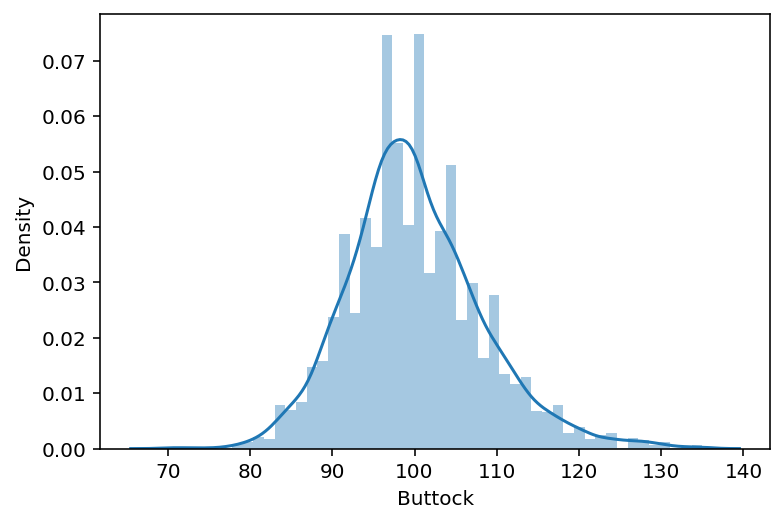

In [274]:
sns.distplot(df_no_outlier['Buttock'])

Text(0, 0.5, 'No of persons')

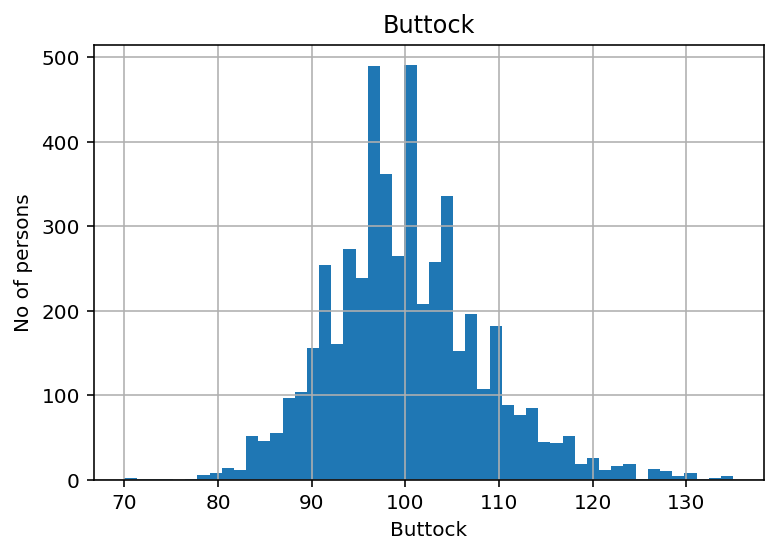

In [275]:
figure=df_no_outlier.Buttock.hist(bins=50)
figure.set_title('Buttock')
figure.set_xlabel('Buttock')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



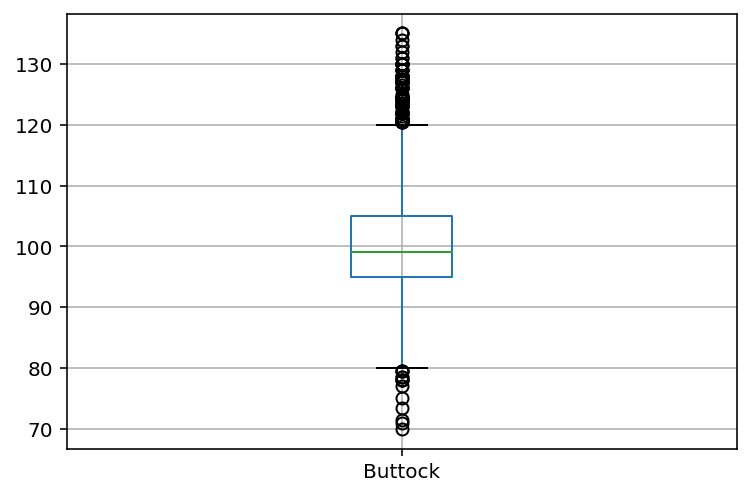

In [276]:
figure=df_no_outlier.boxplot(column="Buttock")

In [277]:
uppper_boundary=df_no_outlier['Buttock'].mean() + 3* df_no_outlier['Buttock'].std()
lower_boundary=df_no_outlier['Buttock'].mean() - 3* df_no_outlier['Buttock'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Buttock'].mean())
print(df_no_outlier.shape)

75.23804290811894
124.857971369097
100.04800713860797
(5043, 12)


In [278]:
df_no_outlier[(df_no_outlier.Buttock<lower_boundary)|(df_no_outlier.Buttock>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
326,0.0,6.0,39.183673,120.0,175.0,58.2,41.5,120.0,127.5,28.0,1,3
377,1.0,11.0,32.490548,110.0,184.0,60.5,39.0,111.0,127.0,29.0,1,3
568,0.0,18.0,38.739669,120.0,176.0,60.3,47.5,123.5,127.0,31.0,1,3
600,0.0,12.0,20.936639,57.0,165.0,54.7,35.0,78.0,70.0,32.0,1,0
627,0.0,0.0,29.387755,90.0,175.0,59.0,45.2,117.5,129.0,32.0,1,3
882,1.0,7.0,40.989084,115.0,167.5,58.0,43.0,122.0,125.0,34.0,1,3
1241,0.0,24.0,41.259414,103.0,158.0,55.0,39.5,118.0,130.0,37.0,1,3
1399,0.0,11.0,37.323292,113.0,174.0,61.0,46.0,123.5,129.0,39.0,1,3
1608,0.0,16.0,38.758395,116.0,173.0,60.0,44.0,122.0,128.0,41.0,1,3
1627,1.0,9.0,42.517007,120.0,168.0,58.0,48.5,124.0,127.0,41.0,1,3


In [279]:
df_no_outlier = df_no_outlier[(df_no_outlier.Buttock>lower_boundary)&(df_no_outlier.Buttock<uppper_boundary)]
df_no_outlier.shape

(4995, 12)

<AxesSubplot:xlabel='Age', ylabel='Density'>

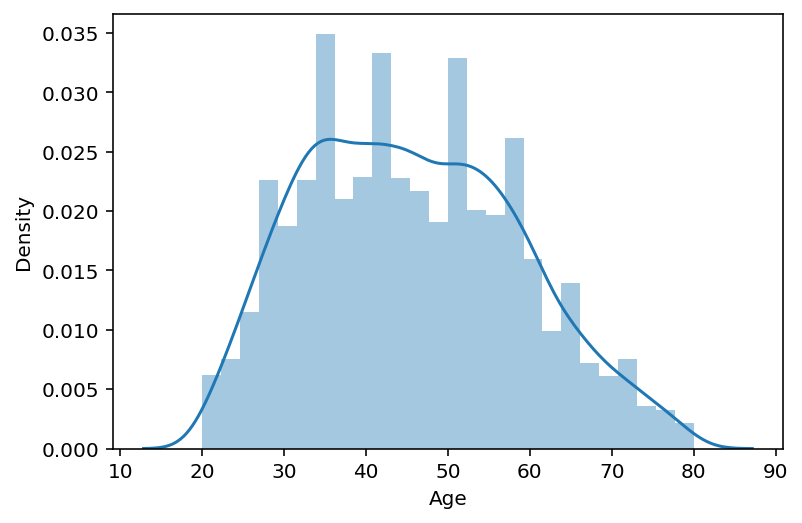

In [280]:
sns.distplot(df_no_outlier['Age'])

Text(0, 0.5, 'No of persons')

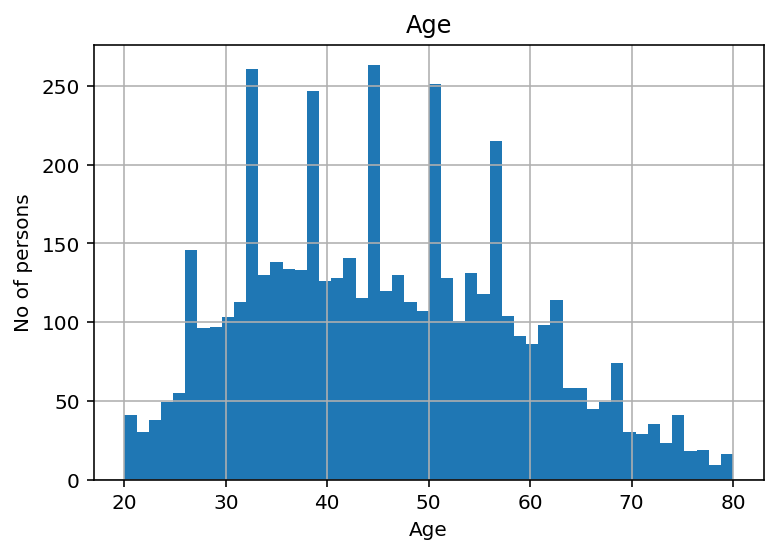

In [281]:
figure=df_no_outlier.Age.hist(bins=50)
figure.set_title('Age')
figure.set_xlabel('Age')
figure.set_ylabel('No of persons')
#figure.set_xlim([0, 100])



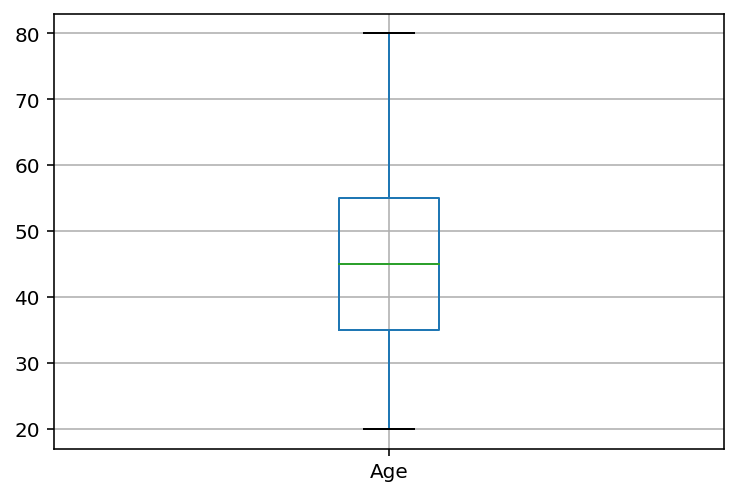

In [282]:
figure=df_no_outlier.boxplot(column="Age")

In [283]:
uppper_boundary=df_no_outlier['Age'].mean() + 3* df_no_outlier['Age'].std()
lower_boundary=df_no_outlier['Age'].mean() - 3* df_no_outlier['Age'].std()
print(lower_boundary), print(uppper_boundary),print(df_no_outlier['Age'].mean())
print(df_no_outlier.shape)

6.397774074248723
84.95377747730282
45.675775775775776
(4995, 12)


In [284]:
df_no_outlier[(df_no_outlier.Age<lower_boundary)|(df_no_outlier.Age>uppper_boundary)]

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status


In [285]:
df_no_outlier = df_no_outlier[(df_no_outlier.Age>lower_boundary)&(df_no_outlier.Age<uppper_boundary)]
df_no_outlier.shape

(4995, 12)

In [286]:
df1=df_no_outlier 

In [287]:
df1.head()

,BQ,ESS,BMI,Weight,Height,Head,Neck,Waist,Buttock,Age,M,status
0,0.0,14.0,29.065927,88.0,174.0,57.5,39.0,95.5,106.5,20.0,1,0
1,0.0,8.0,26.989619,78.0,170.0,57.0,36.5,90.0,100.0,20.0,1,0
2,0.0,16.0,23.939481,75.0,177.0,59.0,39.0,88.0,104.0,20.0,1,0
3,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0
4,0.0,15.0,22.129740,67.0,174.0,57.0,35.0,74.0,94.0,20.0,1,0


In [288]:
X = df1.drop('status', axis=1)   # axis=0 for row, axis=1 for column
y = df1['status']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (3996, 11)
y_train (3996,)
X_test (999, 11)
y_test (999,)


In [289]:
def evaluate(model, X_test , y_test,modelname):
  y_pred1=model.predict(X_test)
  #precision    = precision_score(y_test, y_pred1)
 # recall       = recall_score(y_test, y_pred1)
 # f1score      = f1_score(y_test, y_pred1) 
 # rocauc       = roc_auc_score(y_test, y_pred1)
  #logloss      = log_loss(y_test, y_pred1)
  accuracy     = accuracy_score(y_test, y_pred1)
  confusion    = confusion_matrix(y_test, y_pred1)
  df_model1 = pd.DataFrame({  'model'        : [modelname],
                             'accuracy'     : [accuracy],
                             #'precision'    : [precision],
                             #'recall'       : [recall],
                             #'f1score'      : [f1score],
                             #'rocauc'       : [rocauc],
                            # 'logloss'      : [logloss],
                             'timetaken'    : [time2],
                            'confusionmatrix' : [confusion]
                            
                                }) 
  return df_model1

In [290]:
%%time
time2=time.time()
print("base model")
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)
#base_accuracy = evaluate(base_model, X_test, y_test,modelname)
model1 = evaluate(base_model,  X_test,  y_test, 'RandomForest')
model1.timetaken[0] = time.time() - time2
print("Random Forest")
print(base_model.get_params())

model1

base model
Random Forest
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 1.18 s


,model,accuracy,timetaken,confusionmatrix
0,RandomForest,0.792793,1.17584,"[[485, 0, 0, 77], [2, 0, 0, 0], [3, 0, 0, 0], ..."


In [291]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

time2=time.time()
print("base model")
base_model1 = ExtraTreesClassifier()
base_model1.fit(X_train, y_train)
model2 = evaluate(base_model1,  X_test,  y_test, 'Extra Tree')
model2.timetaken[0] = time.time() - time2
print("Extra Tree")
print(base_model1.get_params())

base model
Extra Tree
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Wall time: 867 ms


In [292]:
%%time
time2=time.time()
print("base model")
base_model2 = LogisticRegression()
base_model2.fit(X_train, y_train)
model3 = evaluate(base_model2,  X_test,  y_test, 'Logistic Regression')
model3.timetaken[0] = time.time() - time2
print("Logoistic Regression")
print(base_model2.get_params())

base model
Logoistic Regression
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Wall time: 261 ms


In [293]:
%%time
time2=time.time()
print("base model")
base_model3 = KNeighborsClassifier()
base_model3.fit(X_train, y_train)
model4 = evaluate(base_model3,  X_test,  y_test, 'KNN')
model4.timetaken[0] = time.time() - time2
print("KNN")
print(base_model3.get_params())

base model
KNN
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Wall time: 114 ms


In [294]:
%%time
time2=time.time()
print("base model")
base_model4 = LinearSVC()
base_model4.fit(X_train, y_train)
model5 = evaluate(base_model4,  X_test,  y_test, 'LinearSVC')
model5.timetaken[0] = time.time() - time2
print("LinearSVC")
print(base_model4.get_params())

base model
LinearSVC
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Wall time: 1.18 s


In [295]:
%%time
time2=time.time()
print("base model")
base_model5 = GaussianNB()
base_model5.fit(X_train, y_train)
model6 = evaluate(base_model5,  X_test,  y_test, 'GaussianNB')
model6.timetaken[0] = time.time() - time2
print("GaussianNB")
print(base_model5.get_params())

base model
GaussianNB
{'priors': None, 'var_smoothing': 1e-09}
Wall time: 11.9 ms


In [296]:
%%time
time2=time.time()
print("base model")
base_model6=SVC()
base_model6.fit(X_train, y_train)
model7 = evaluate(base_model6,  X_test,  y_test, 'SVC')
model7.timetaken[0] = time.time() - time2
print("SVC")
print(base_model6.get_params())

base model
SVC
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Wall time: 1.35 s


In [297]:
%%time
time2=time.time()
print("base model")
base_model7=DecisionTreeClassifier()
base_model7.fit(X_train, y_train)
model8 = evaluate(base_model7,  X_test,  y_test, 'Decision Tree')
model8.timetaken[0] = time.time() - time2
print("Decision Tree")
print(base_model7.get_params())

base model
Decision Tree
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Wall time: 60.7 ms


In [298]:
df_base= pd.concat([model1,model2,model3,model4,model5,model6,model7,model8],axis = 0).reset_index()
df_base.drop('index', axis=1, inplace=True)
df_base

,model,accuracy,timetaken,confusionmatrix
0,RandomForest,0.792793,1.175840,"[[485, 0, 0, 77], [2, 0, 0, 0], [3, 0, 0, 0], ..."
1,Extra Tree,0.797798,0.866577,"[[485, 0, 0, 77], [2, 0, 0, 0], [3, 0, 0, 0], ..."
2,Logistic Regression,0.779780,0.261413,"[[472, 0, 0, 90], [2, 0, 0, 0], [3, 0, 0, 0], ..."
3,KNN,0.763764,0.113533,"[[452, 0, 0, 110], [2, 0, 0, 0], [2, 0, 0, 1],..."
4,LinearSVC,0.659660,1.182713,"[[549, 0, 0, 13], [2, 0, 0, 0], [3, 0, 0, 0], ..."
5,GaussianNB,0.749750,0.011893,"[[419, 1, 0, 142], [1, 0, 0, 1], [2, 0, 0, 1],..."
6,SVC,0.773774,1.334516,"[[469, 0, 0, 93], [2, 0, 0, 0], [2, 0, 0, 1], ..."
7,Decision Tree,0.739740,0.045027,"[[434, 0, 1, 127], [1, 0, 0, 1], [3, 0, 0, 0],..."
